<a href="https://www.kaggle.com/code/kapturovalexander/kapturov-s-solution-of-ps-s4e1?scriptVersionId=160392869" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <span style="border: 3px solid orange; border-radius: 25px; color: white; background-image: url(https://www.kaggle.com/competitions/65711/images/header); padding: 1px 5px 5px 5px">Binary Classification with a Bank Churn Dataset</span>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv
/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


![](https://www.kaggle.com/competitions/65711/images/header)

# <span style="background-image: url(https://www.kaggle.com/competitions/65711/images/header); color: white; font-size: 50px;">Table of Contents</span>
​
1. [Import libraries](#1)
2. [Open data files](#2)
3. [Show first 5 lines of train data](#3)
    - 3.1 [Compare original train and competition train](#3.1)
    - 3.2 [Concatenate original train with competition train](#3.2)
4. [Shapes of train and test data](#4)
5. [Display descriptive statistics of train data](#5)
6. [Check the number of gaps for each feature](#6)
7. [Data types of training set](#7)
    - 7.1 [Figure out how much duplicates in data](#7.1)
    - 7.2 [Remove duplicates from data](#7.2)
8. [Display histograms of distribution](#8)
9. [Let's count target of train data](#9)
10. [Transorm the data with logarithm](#10)
    - 10.1 [Pie plot of Exited](#10.1)
    - 10.2 [Feature importance](#10.2)
11. [Build a heat map of correlations](#11)
12. [Define base models with tuned hyperparameters](#12)
13. [Defining the meta-model with tuned hyperparameters](#13)
14. [Creating and fitting the stacking model](#14)
15. [Predict probabilitions on the validation set and calculate ROC AUC score](#15)
16. [Predict probabilities on the test data](#16)
17. [Build DataFrame and make first submission](#17)

## <p style="color: #00b2ff; border-style: solid; border-color: orange; padding: 5px 5px 5px 5px; border-width: 5px;">The bank customer churn dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be a customer.

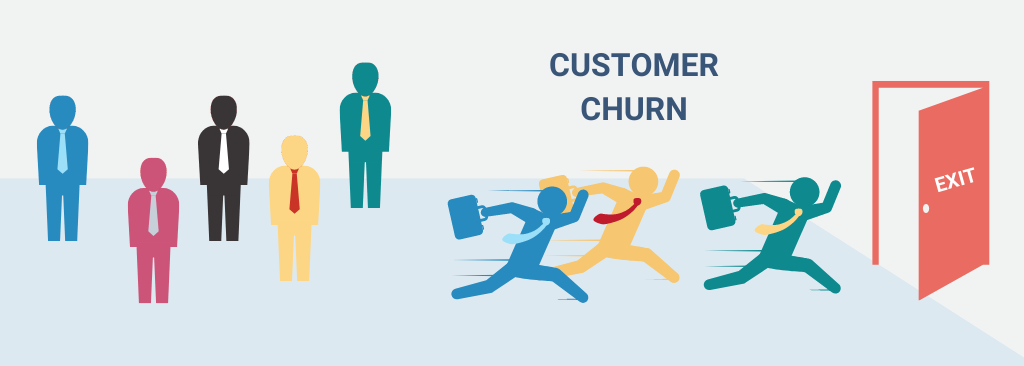

<a id='1'></a>
# <span style="color: blue; border-bottom: 6px solid #03adfc;background-color: #fadb8c;">🏃‍♀️ 1 - Import libraries</span>

In [2]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

<a id='2'></a>
# <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🏃‍♂️ 2 - Open data files</span>

In [3]:
original_train = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')

train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')

<a id='3'></a>
# <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">😒 3 - Show first 5 lines of train data</span>

In [4]:
# Show all properties on display
pd.set_option('display.max_columns', None)

train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [5]:
HTML("""
<style>
  .custom-style {
    font-family: Verdana;
    color: white;
    background-image: url(https://www.kaggle.com/competitions/65711/images/header);
    font-weight: bold;
    font-size: 16px;
  },
  .chapter {
    color: blue; 
    border-style: solid; 
    background-color: orange;
    border-width: 5px;
  },
</style>


<ol>
  <li><span class="custom-style">Customer ID</span>: A unique identifier for each customer</li>
  <li><span class="custom-style">Surname</span>: The customer's surname or last name</li>
  <li><span class="custom-style">Credit Score</span>: A numerical value representing the customer's credit score</li>
  <li><span class="custom-style">Geography</span>: The country where the customer resides (France, Spain, or Germany)</li>
  <li><span class="custom-style">Gender</span>: The customer's gender (Male or Female)</li>
  <li><span class="custom-style">Age</span>: The customer's age.</li>
  <li><span class="custom-style">Tenure</span>: The number of years the customer has been with the bank</li>
  <li><span class="custom-style">Balance</span>: The customer's account balance</li>
  <li><span class="custom-style">NumOfProducts</span>: The number of bank products the customer uses (e.g., savings account, credit card)</li>
  <li><span class="custom-style">HasCrCard</span>: Whether the customer has a credit card (1 = yes, 0 = no)</li>
  <li><span class="custom-style">IsActiveMember</span>: Whether the customer is an active member (1 = yes, 0 = no)</li>
  <li><span class="custom-style">EstimatedSalary</span>: The estimated salary of the customer</li>
  <li><span class="custom-style">Exited</span>: Whether the customer has churned (1 = yes, 0 = no)</li>
</ol>
""")

<a id='3.1'></a>
### <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">3.1 Compare original train and competition train

In [6]:
print(original_train.shape)
original_train.columns.tolist()

(10002, 14)


['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [7]:
print(train.shape)
train.columns.tolist()

(165034, 14)


['id',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

##### We have to drop 'id' from competition dataset and 'RowNumber' in original dataset

In [8]:
train.drop(columns='id', axis=1, inplace=True)
test.drop(columns='id', axis=1, inplace=True)
original_train.drop(columns='RowNumber', axis=1, inplace=True)

<a id='3.2'></a>
#### <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">3.2 Concatenate original train with competition train

In [9]:
print(f'Train data: {train.shape}')

Train data: (165034, 13)


In [10]:
train = pd.concat(objs=[train, original_train])
train.shape

(175036, 13)

##### Now You can see that train data became +10K objectives bigger than previous data

<a id='4'></a>
# <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🏦 4 - Shapes of train and test data</span>

In [11]:
print(f'Train data: {train.shape}')
print(f'Test data: {test.shape}\n')

train_data_percentage = np.round(train.shape[0] / (train.shape[0] + test.shape[0]), 4)
print(f'Train data consists of {train_data_percentage * 100}% of all observations')
print(f'Test data consists of {(1 - train_data_percentage) * 100}% of all observations')

Train data: (175036, 13)
Test data: (110023, 12)

Train data consists of 61.4% of all observations
Test data consists of 38.6% of all observations


<a id='5'></a>
# <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">😀 5 - Display descriptive statistics of train data</span>

In [12]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerId,175036.0,1.569194e+07,71428.662023,15565701.00,15632882.00,15690169.00,15756655.00,15815690.00
CreditScore,175036.0,6.561173e+02,81.151830,350.00,597.00,659.00,710.00,850.00
Age,175035.0,3.817139e+01,8.969523,18.00,32.00,37.00,42.00,92.00
Tenure,175036.0,5.019904e+00,2.811125,0.00,3.00,5.00,7.00,10.00
Balance,175036.0,5.667882e+04,62982.466070,0.00,0.00,0.00,120729.77,250898.09
NumOfProducts,175036.0,1.553069e+00,0.549210,1.00,1.00,2.00,2.00,4.00
HasCrCard,175035.0,7.511869e-01,0.432327,0.00,1.00,1.00,1.00,1.00
IsActiveMember,175035.0,4.987517e-01,0.500000,0.00,0.00,0.00,1.00,1.00
EstimatedSalary,175036.0,1.118610e+05,50815.418008,11.58,73181.39,116969.73,154767.34,199992.48
Exited,175036.0,2.111508e-01,0.408126,0.00,0.00,0.00,0.00,1.00


<a id='6'></a>
# <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">💵 6 - Check the number of gaps for each feature</span>

In [13]:
print('TRAIN data\n')
print(f'{train.isna().sum()}\n\n\n')

print('TEST data\n')
print(train.isna().sum())

TRAIN data

CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64



TEST data

CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64


##### There are few lost values in data. Solve this problem later

<a id='7'></a>
# <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">💴 7 - Data types of training set</span>

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175036 entries, 0 to 10001
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       175036 non-null  int64  
 1   Surname          175036 non-null  object 
 2   CreditScore      175036 non-null  int64  
 3   Geography        175035 non-null  object 
 4   Gender           175036 non-null  object 
 5   Age              175035 non-null  float64
 6   Tenure           175036 non-null  int64  
 7   Balance          175036 non-null  float64
 8   NumOfProducts    175036 non-null  int64  
 9   HasCrCard        175035 non-null  float64
 10  IsActiveMember   175035 non-null  float64
 11  EstimatedSalary  175036 non-null  float64
 12  Exited           175036 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 18.7+ MB


##### Surname, Geography and Gender features are objects, so we have to do one-hot encoding

In [15]:
train.Surname.value_counts()

Surname
Hsia         2474
T'ien        2300
Hs?          1626
Maclean      1601
Kao          1597
             ... 
Vigano          1
Drake           1
McChesney       1
Du Cane         1
Wells           1
Name: count, Length: 2932, dtype: int64

##### There are too many different surnames. So we won't do one-hot encoding with surname and just drop this feature from datasets. I also will check how other Kaggle tackle with this feature

In [16]:
train.drop('Surname', axis=1, inplace=True)
test.drop('Surname', axis=1, inplace=True)

In [17]:
train.Geography.value_counts()

Geography
France     99229
Spain      38690
Germany    37116
Name: count, dtype: int64

In [18]:
train.Gender.value_counts()

Gender
Male      98608
Female    76428
Name: count, dtype: int64

In [19]:
# One-hot encoding
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

<a id="7.1"></a>
#### <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">7.1 Figure out how much duplicates in data

In [20]:
train_duplicates_number = train[train.duplicated()]
test_duplicates_number = test[test.duplicated()]
                             
print(len(train_duplicates_number))
print(len(test_duplicates_number))

199
19


##### There are 199 duplicates in train data and 19 in test data. Let's remove them!

<a id="7.2"></a>
#### <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">7.2 Remove duplicates from data

In [21]:
train = train.drop_duplicates()
# test = test.drop_duplicates()

# Check whether all duplicates were removed
train_duplicates = train[train.duplicated()]
# test_duplicates = test[test.duplicated()]
print(len(train_duplicates))
# print(len(test_duplicates))

0


##### As we see now there is no more duplicates!

<a id='8'></a>
# <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">💶 8 - Display histograms of distribution</span>

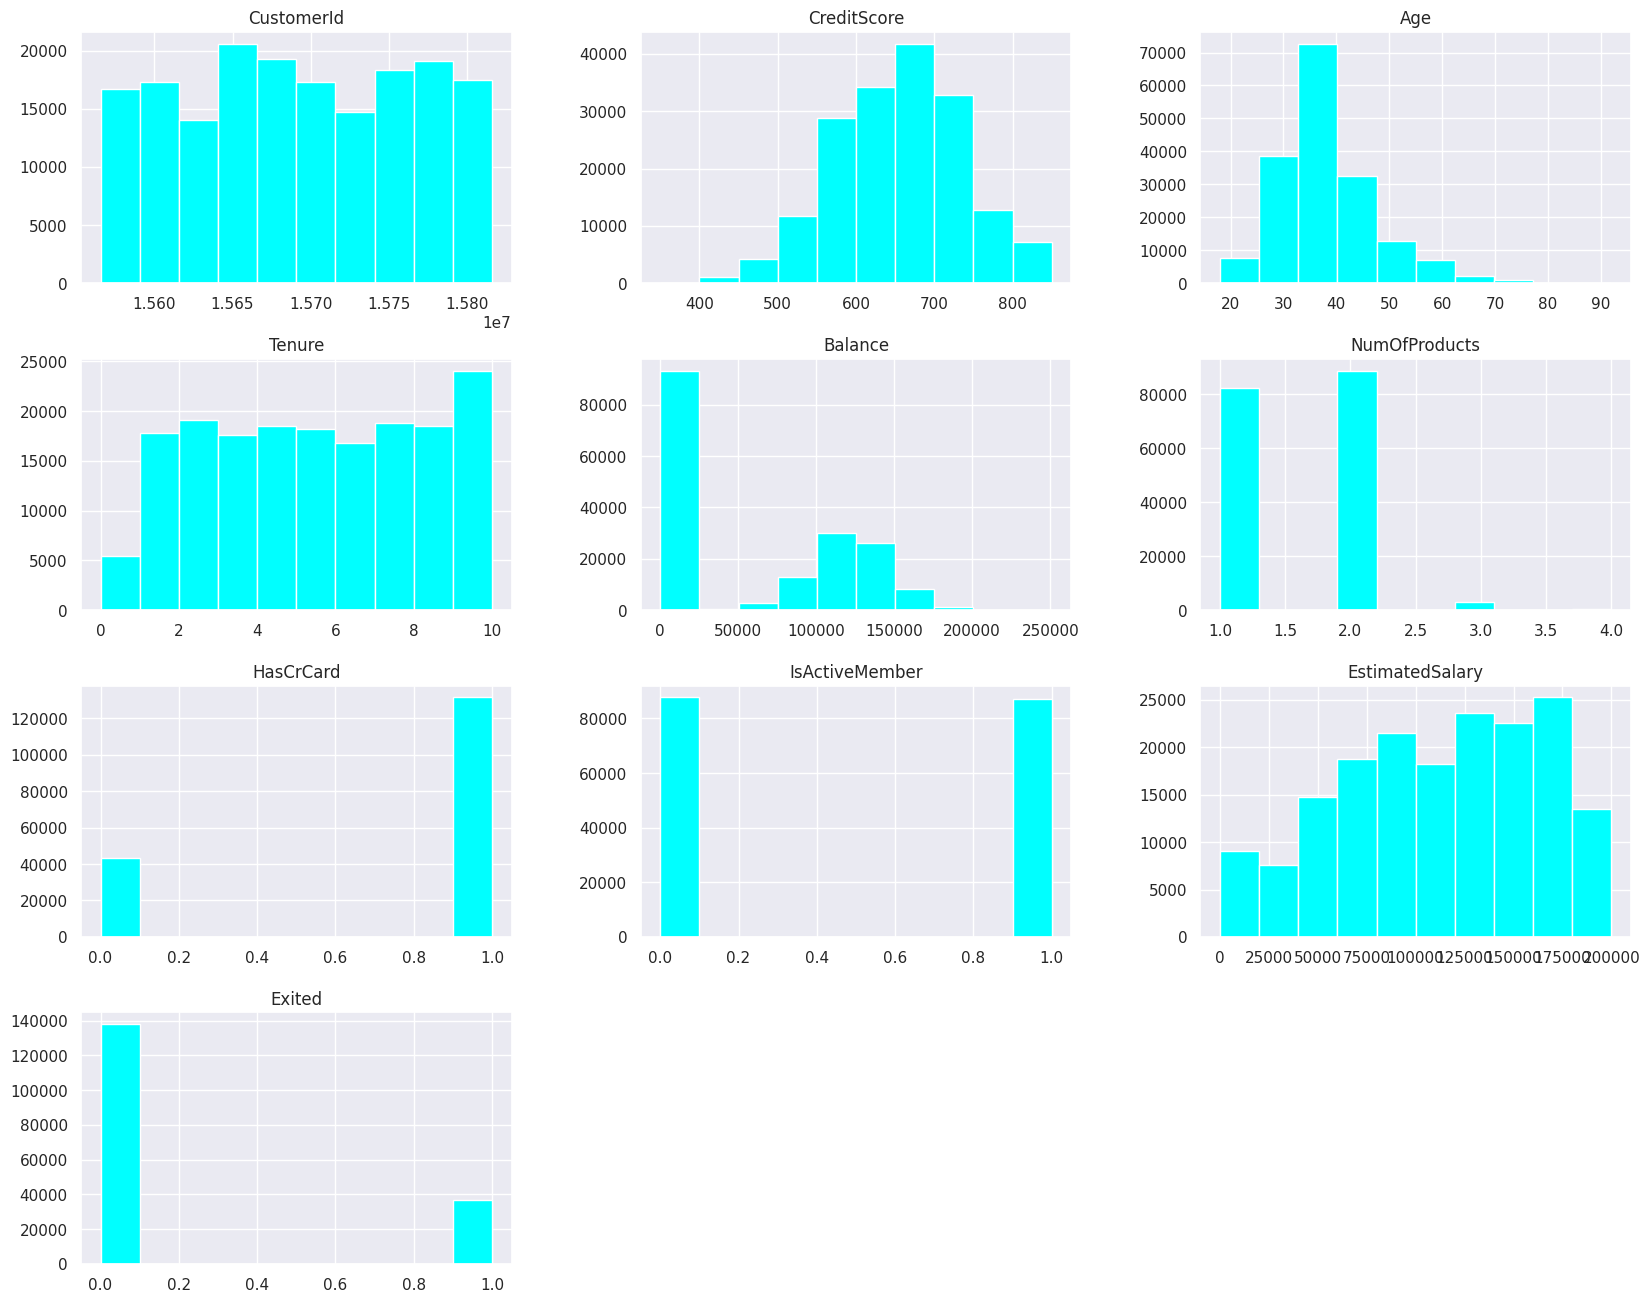

In [22]:
sns.set(rc={'figure.figsize': (20, 16)})
train.hist(color='aqua');

<a id='9'></a>
# <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">💷 9 - Let's count target of train data</span>

In [23]:
print(f'{train.Exited.value_counts()}\n\n')
print(train.Exited.value_counts() / train.shape[0])

Exited
0    137910
1     36927
Name: count, dtype: int64


Exited
0    0.788792
1    0.211208
Name: count, dtype: float64


##### Target classes are inbalanced

![](https://miro.medium.com/v2/resize:fit:928/1*S3p9A6Sjnsl_fo3cAHSoZA.png)

##### Exited indicates whether the individual leave the bank or not.

<a id='10'></a>
# <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">💳 10 - Transorm the data with logarithm</span>

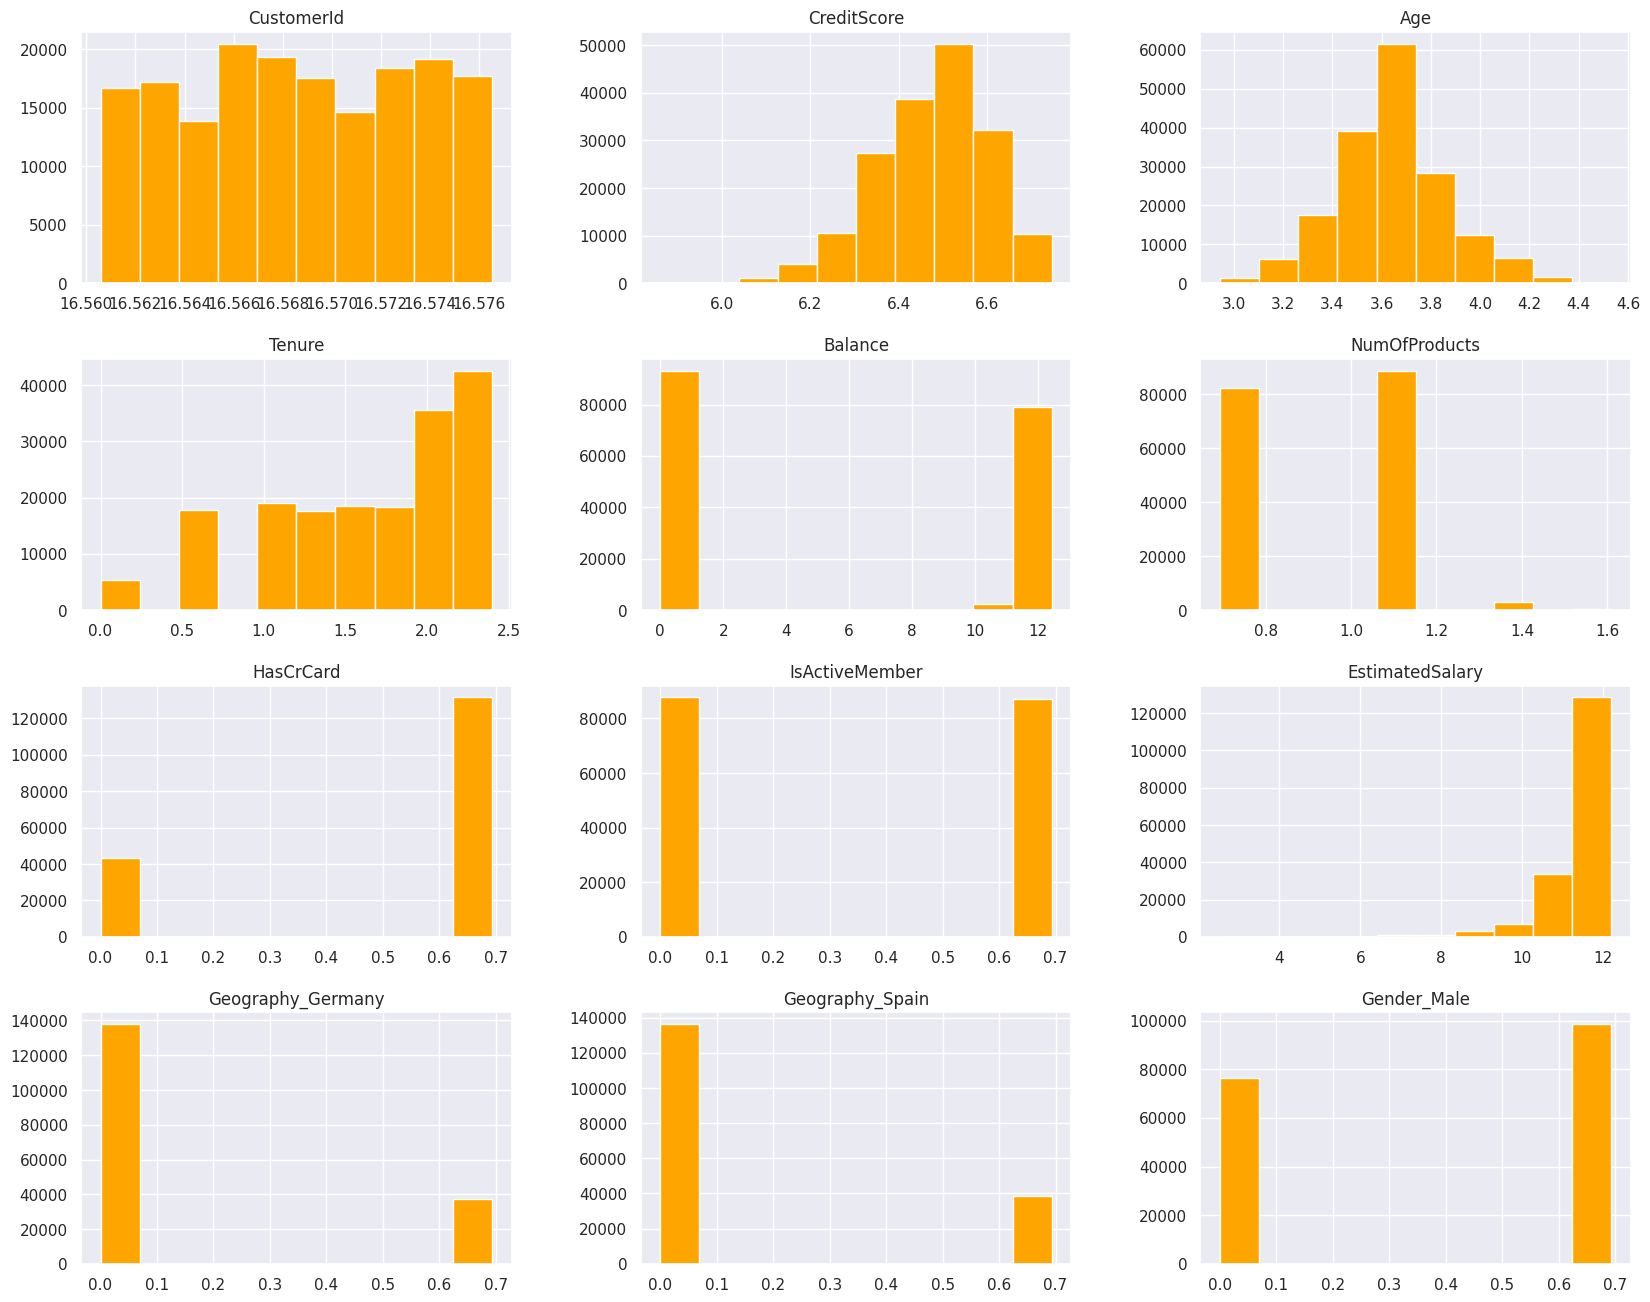

In [24]:
# Split the train data into X and y
X = train.drop(['Exited'], axis=1)
y = train.Exited

for column in X.columns.tolist():
    X[column] = X[column].apply(lambda x: np.log(x + 1))
    
# Transform test data
for column in test.columns.tolist():
    test[column] = test[column].apply(lambda x: np.log(x + 1))
    
X.hist(color='orange');

<a id='10.1'></a>
#### <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">10.1 - Pie plot of Exited</span>

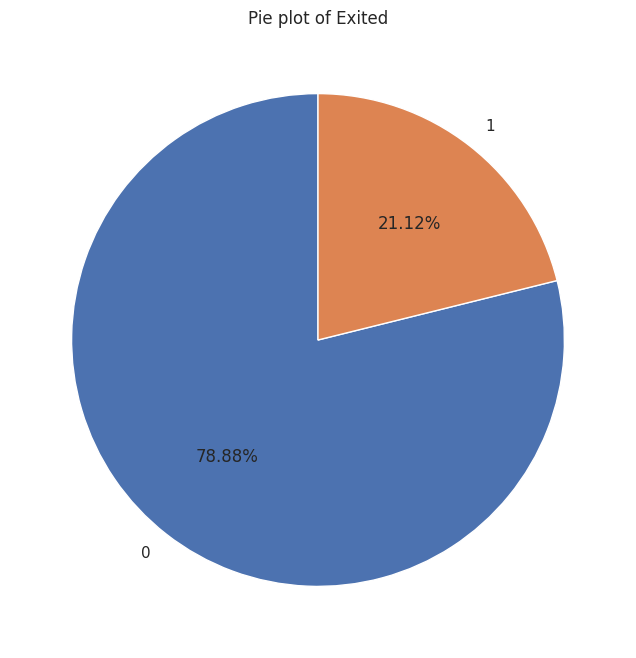

In [25]:
label_counts = y.value_counts()

plt.figure(figsize=(12, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.2f%%', startangle=90)
plt.title('Pie plot of Exited')
plt.show();

##### Each 5th client leaves the bank

<a id='10.2'></a>
#### <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">10.2 Feature importance

In [26]:
X = X.fillna(0)

CPU times: user 5min 21s, sys: 840 ms, total: 5min 22s
Wall time: 5min 22s


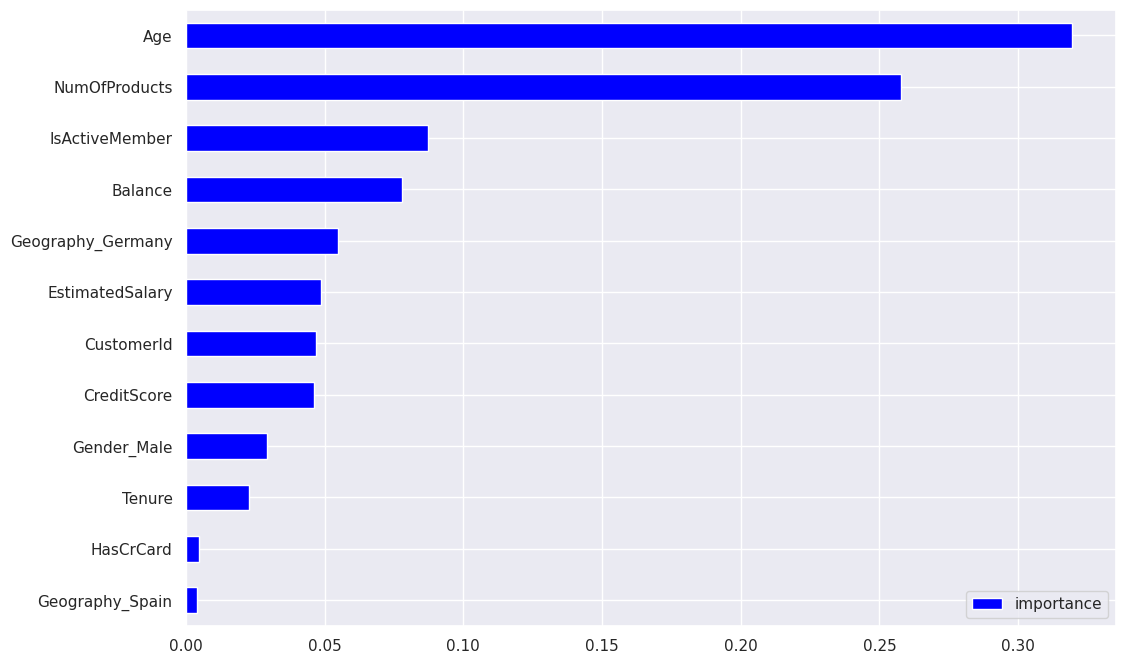

In [27]:
%%time
best_forest = RandomForestClassifier(
    n_estimators=925,
    min_samples_split=2,
    min_samples_leaf=11,
    max_depth=20,
    random_state=27,
)
    
best_forest.fit(X, y)
importance = best_forest.feature_importances_
feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')
feature_importance.plot(kind='barh', figsize=(12, 8), color='blue');

<a id='11'></a>
# <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">💸 11 - Build a heat map of correlations</span>

In [28]:
correlation = X.corr()
correlation.style.background_gradient(cmap='coolwarm')

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
CustomerId,1.000000,0.006602,0.003008,-0.003960,-0.006452,0.005831,-0.006071,-0.002825,0.003301,-0.004378,0.001267,-0.001913
CreditScore,0.006602,1.000000,-0.009565,0.000983,0.003617,0.012701,-0.000021,0.015442,0.000851,0.001920,0.002954,0.002712
Age,0.003008,-0.009565,1.000000,-0.012274,0.063506,-0.109136,-0.010998,-0.003068,-0.004420,0.090895,-0.012434,-0.059070
Tenure,-0.003960,0.000983,-0.012274,1.000000,-0.016704,0.013316,0.009801,-0.007148,0.000774,-0.010626,0.002975,0.009900
Balance,-0.006452,0.003617,0.063506,-0.016704,1.000000,-0.387704,-0.022819,-0.013999,0.011480,0.551450,-0.135529,-0.015924
NumOfProducts,0.005831,0.012701,-0.109136,0.013316,-0.387704,1.000000,0.006878,0.043815,-0.004265,-0.106827,0.026733,0.027988
HasCrCard,-0.006071,-0.000021,-0.010998,0.009801,-0.022819,0.006878,1.000000,-0.020894,0.008018,-0.004542,-0.014524,0.006472
IsActiveMember,-0.002825,0.015442,-0.003068,-0.007148,-0.013999,0.043815,-0.020894,1.000000,-0.007532,-0.035302,0.014753,0.033153
EstimatedSalary,0.003301,0.000851,-0.004420,0.000774,0.011480,-0.004265,0.008018,-0.007532,1.000000,0.011078,-0.010805,-0.001999
Geography_Germany,-0.004378,0.001920,0.090895,-0.010626,0.551450,-0.106827,-0.004542,-0.035302,0.011078,1.000000,-0.276346,-0.038918


<a id='12'></a>
# <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🏧 12 - Define base models with tuned hyperparameters</span>

In [29]:
base_models = [
    ('catboost', CatBoostClassifier(
        iterations=275,
        learning_rate=0.01,
        depth=10,
        random_state=27,
    )),
    ('xgboost', XGBClassifier(
        n_estimators=145,
        learning_rate=0.01,
        max_depth=42,
        random_state=27,
        eval_metric='auc'
    )),
    ('lightgbm', LGBMClassifier(
        n_estimators=915,
        learning_rate=0.05,
        max_depth=14,
        random_state=27,
    )),
    ('random_forest', RandomForestClassifier(
        n_estimators=925,
        min_samples_split=2,
        min_samples_leaf=11,
        max_depth=20,
        random_state=27,
    )),
    ('logistic_regression', LogisticRegression(
        solver='liblinear',
        penalty='l1',
        max_iter=575,
        random_state=27,
    )),
#     ('knn_classifier', KNeighborsClassifier(
#         n_neighbors=10,
#         metric='minkowski',
#         leaf_size=52,
#         algorithm='kd_tree'
#     )),
#     ('hist_grad_boost_classifier', HistGradientBoostingClassifier(
#         min_samples_leaf=4,
#         max_leaf_nodes=34,
#         max_iter=650,
#         max_depth=61,
#         learning_rate=0.1
#     )),
    ('ada_boost_classifier', AdaBoostClassifier(
        n_estimators=895,
        learning_rate=0.05
    )),
]

<a id='13'></a>
# <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">💹 13 - Defining the meta-model with tuned hyperparameters</span>

## <span style="background-image: url(https://www.kaggle.com/competitions/65711/images/header); color: white; font-size: 30px;">Logistic Regression</span>

In [30]:
# # Searching for best parameters of Logistic Regression

# random = LogisticRegression(random_state=27)

# parameters = {
#     'penalty': ('l1', 'l2', 'elasticnet'),
#     'solver': ('lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'),
#     'max_iter': range(25, 1001, 25)
# }

# random_search = RandomizedSearchCV(estimator=random, param_distributions=parameters, n_iter=10, n_jobs=-1, cv=5)
# random_search.fit(X, y)
# print(random_search.best_params_)

{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 575}

{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 575}

## <span style="background-image: url(https://www.kaggle.com/competitions/65711/images/header); color: white; font-size: 30px;">KNeighbors Classifier</span>

In [31]:
# # Searching for best parameters of KNeighbors Classifier

# random = KNeighborsClassifier()

# parameters = {
#     'n_neighbors': range(2, 11),
#     'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
#     'leaf_size': range(2, 100, 2),
#     'metric': ('cosine', 'euclidean', 'minkowski')
# }

# random_search = RandomizedSearchCV(estimator=random, param_distributions=parameters, n_iter=10, n_jobs=-1, cv=5)
# random_search.fit(X, y)
# print(random_search.best_params_)

{'n_neighbors': 10, 'metric': 'minkowski', 'leaf_size': 52, 'algorithm': 'kd_tree'}

{'n_neighbors': 10,
 'metric': 'minkowski',
 'leaf_size': 52,
 'algorithm': 'kd_tree'}

## <span style="background-image: url(https://www.kaggle.com/competitions/65711/images/header); color: white; font-size: 30px;">Random Forest</span>

In [32]:
# # Searching for best parameters of Random Forest

# random = RandomForestClassifier(random_state=27)

# parameters = {
#     'n_estimators': range(50, 1000, 25),
#     'max_depth': range(2, 30, 2),
#     'min_samples_leaf': range(1, 101, 10),
#     'min_samples_split': range(2, 101, 10)
# }

# random_search = RandomizedSearchCV(estimator=random, param_distributions=parameters, n_iter=20, n_jobs=-1, cv=5, verbose=4)
# random_search.fit(X, y)
# print(random_search.best_params_)

{'n_estimators': 925, 'min_samples_split': 2, 'min_samples_leaf': 11, 'max_depth': 20}

{'n_estimators': 925,
 'min_samples_split': 2,
 'min_samples_leaf': 11,
 'max_depth': 20}

## <span style="background-image: url(https://www.kaggle.com/competitions/65711/images/header); color: white; font-size: 30px;">Cat Boost</span>

In [33]:
# # Searching for best parameters of CatBoost

# cat = CatBoostClassifier(learning_rate=0.1, random_state=26)

# parameters = {
#     'iterations': range(25, 1001, 25),
#     'depth': range(2, 17),
#     'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001]
# }

# random_search = RandomizedSearchCV(estimator=cat, param_distributions=parameters, n_iter=100, n_jobs=-1, cv=5, verbose=2)
# random_search.fit(X, y)
# print(random_search.best_params_)

{'learning_rate': 0.01, 'iterations': 275, 'depth': 10}

{'learning_rate': 0.01, 'iterations': 275, 'depth': 10}

## <span style="background-image: url(https://www.kaggle.com/competitions/65711/images/header); color: white; font-size: 30px;">XGBoost</span>

In [34]:
# # Searching for best parameters of XGBoost

# xgb = XGBClassifier(random_state=27)

# xgb_parameters = {
#     'n_estimators': range(5, 1001, 10),
#     'learning_rate': [0.001, 0.05, 0.01],
#     'max_depth': range(2, 100, 4),
# }

# xgb_random_search = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_parameters, n_iter=20, n_jobs=-1, cv=5, verbose=4)
# xgb_random_search.fit(X, y)
# print(f'Best params: {xgb_random_search.best_params_}')

{'n_estimators': 145, 'max_depth': 42, 'learning_rate': 0.01}

{'n_estimators': 145, 'max_depth': 42, 'learning_rate': 0.01}

## <span style="background-image: url(https://www.kaggle.com/competitions/65711/images/header); color: white; font-size: 30px;">LightGBM</span>

In [35]:
# # Searching for best parameters of LightGBM

# lgbm = LGBMClassifier(random_state=27)

# lgbm_parameters = {
#     'n_estimators': range(5, 1001, 10),
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': range(2, 100, 2),
# }

# lgbm_random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=lgbm_parameters, n_jobs=-1, cv=5, verbose=4)
# lgbm_random_search.fit(X, y)
# print(lgbm_random_search.best_params_)

{'n_estimators': 915, 'max_depth': 14, 'learning_rate': 0.05}

{'n_estimators': 915, 'max_depth': 14, 'learning_rate': 0.05}

## <span style="background-image: url(https://www.kaggle.com/competitions/65711/images/header); color: white; font-size: 30px;">Hist Gradient Boosting Classifier</span>

In [36]:
# # Searching for best parameters of Hist Gradient Boosting Classifier

# hgbc = HistGradientBoostingClassifier(random_state=27)

# hgbc_parameters = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_iter': range(25, 1001, 25),
#     'max_leaf_nodes': range(2, 101, 2),
#     'max_depth': range(3, 100, 2),
#     'min_samples_leaf': range(2, 101, 2),
# }

# hgbc_random_search = RandomizedSearchCV(estimator=hgbc, param_distributions=hgbc_parameters, n_jobs=-1, cv=5, verbose=2)
# hgbc_random_search.fit(X, y)
# print(hgbc_random_search.best_params_)

{'min_samples_leaf': 4, 'max_leaf_nodes': 34, 'max_iter': 650, 'max_depth': 61, 'learning_rate': 0.1}

{'min_samples_leaf': 4,
 'max_leaf_nodes': 34,
 'max_iter': 650,
 'max_depth': 61,
 'learning_rate': 0.1}

## <span style="background-image: url(https://www.kaggle.com/competitions/65711/images/header); color: white; font-size: 30px;">Ada Boost Classifier</span>

In [37]:
# # Searching for best parameters of Hist Gradient Boosting Classifier

# ada = AdaBoostClassifier(random_state=27)

# ada_parameters = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': range(25, 1001, 5),
# }

# ada_random_search = RandomizedSearchCV(estimator=ada, param_distributions=ada_parameters, n_jobs=-1, cv=5, verbose=2)
# ada_random_search.fit(X, y)
# print(ada_random_search.best_params_)

{'n_estimators': 895, 'learning_rate': 0.05}

{'n_estimators': 895, 'learning_rate': 0.05}

In [38]:
meta_model = CatBoostClassifier(
    iterations=275,
    learning_rate=0.01,
    depth=10,
    random_state=27
)

<a id='14'></a>
# <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">💱 14 - Creating and fitting the stacking model

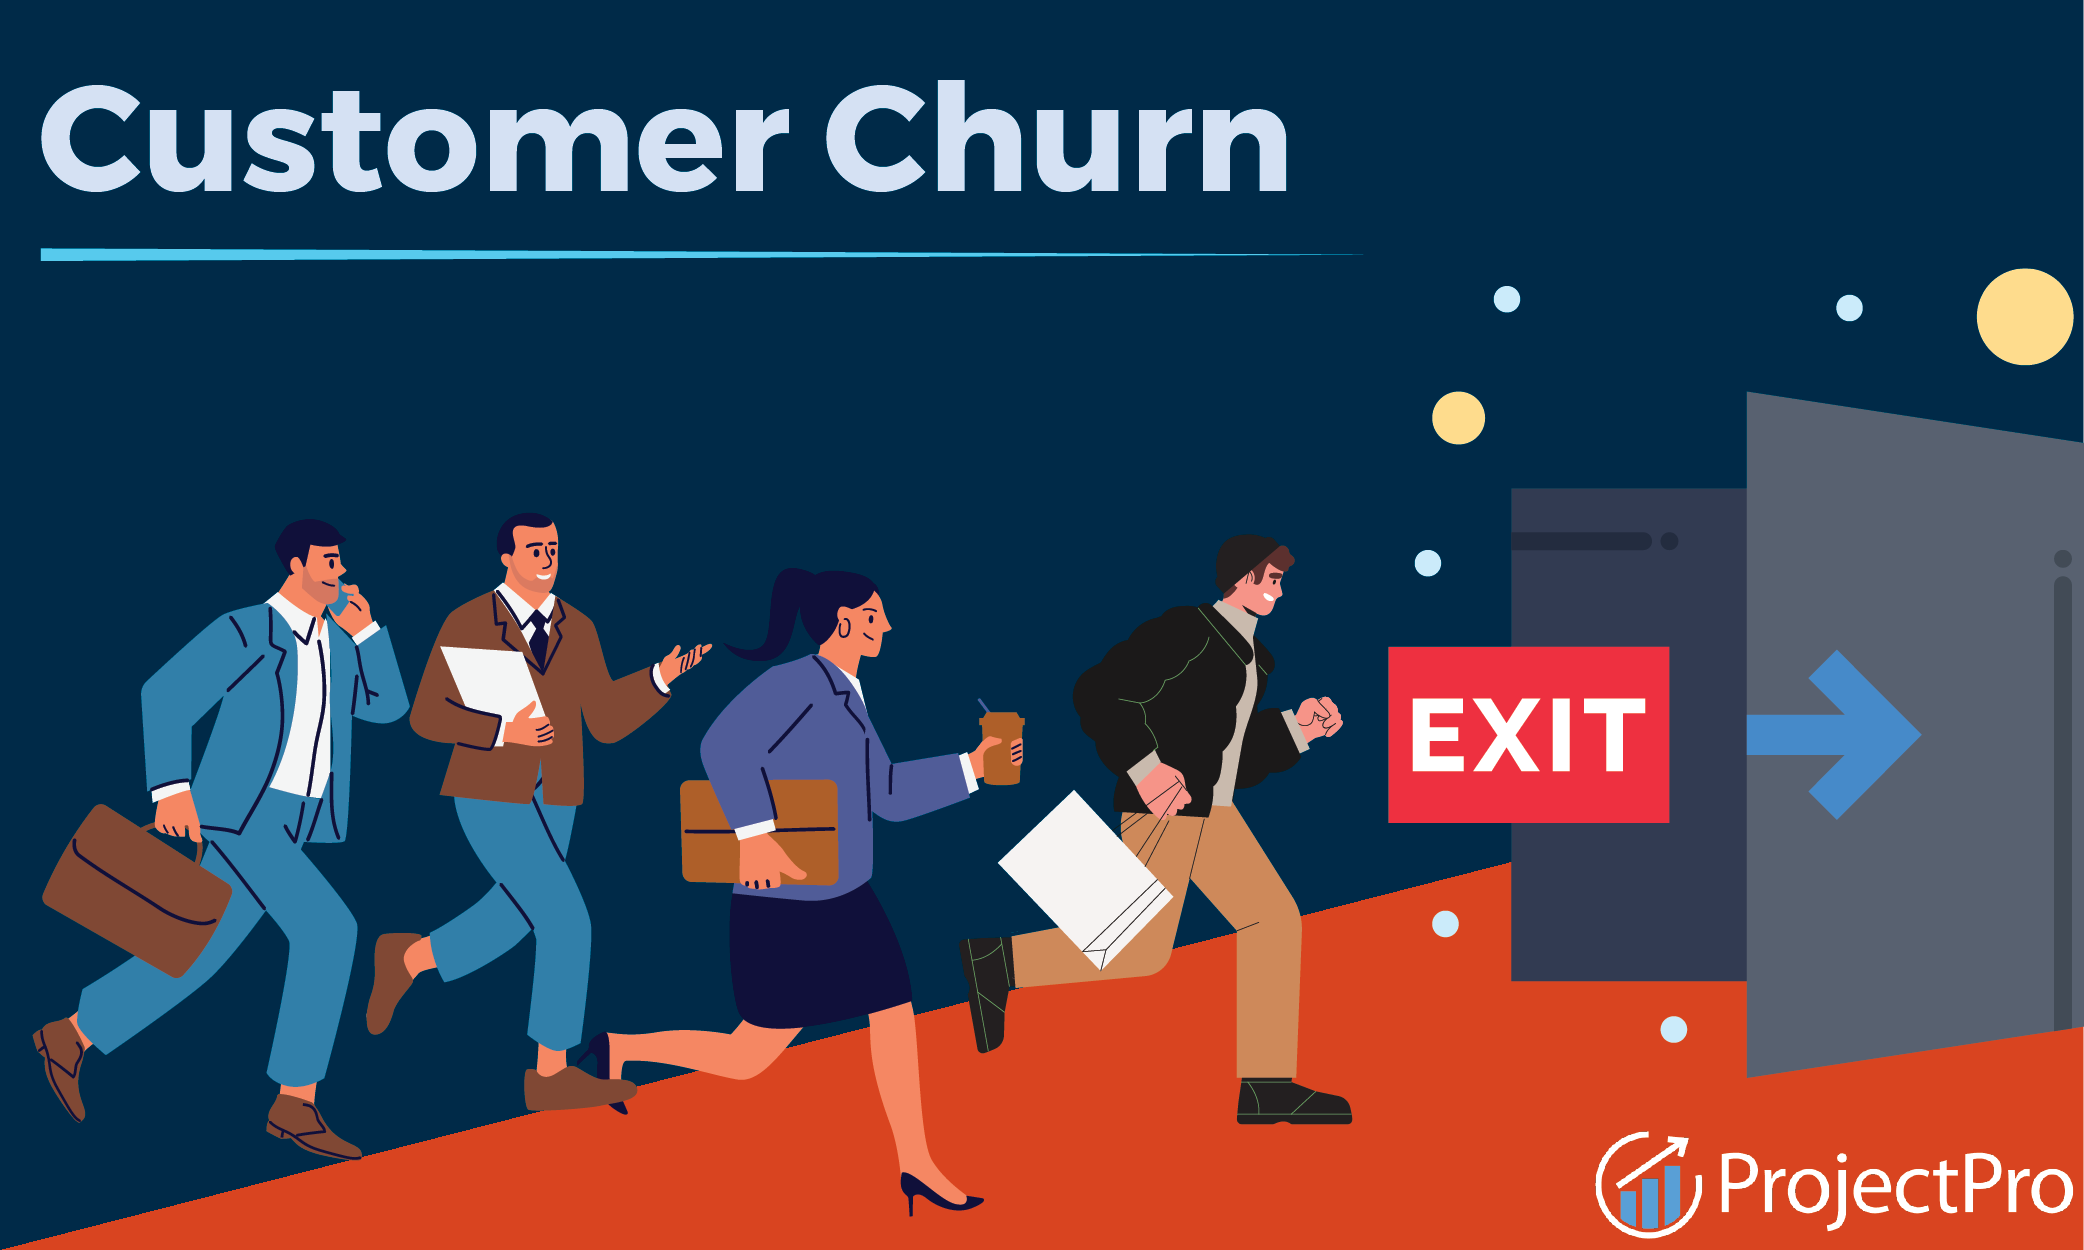

In [39]:
%%time
X_train, X_val, y_val, y_val = train_test_split(X, y, test_size=0.2, random_state=26)

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(X, y)

0:	learn: 0.6830625	total: 135ms	remaining: 37.1s
1:	learn: 0.6728412	total: 207ms	remaining: 28.3s
2:	learn: 0.6630457	total: 280ms	remaining: 25.4s
3:	learn: 0.6535896	total: 346ms	remaining: 23.4s
4:	learn: 0.6442674	total: 407ms	remaining: 22s
5:	learn: 0.6356659	total: 446ms	remaining: 20s
6:	learn: 0.6269647	total: 511ms	remaining: 19.6s
7:	learn: 0.6183839	total: 574ms	remaining: 19.2s
8:	learn: 0.6101818	total: 623ms	remaining: 18.4s
9:	learn: 0.6021750	total: 691ms	remaining: 18.3s
10:	learn: 0.5945372	total: 758ms	remaining: 18.2s
11:	learn: 0.5869727	total: 836ms	remaining: 18.3s
12:	learn: 0.5795975	total: 903ms	remaining: 18.2s
13:	learn: 0.5723952	total: 968ms	remaining: 18.1s
14:	learn: 0.5654464	total: 1.03s	remaining: 17.9s
15:	learn: 0.5587255	total: 1.11s	remaining: 18s
16:	learn: 0.5521600	total: 1.18s	remaining: 17.9s
17:	learn: 0.5457950	total: 1.25s	remaining: 17.8s
18:	learn: 0.5396497	total: 1.32s	remaining: 17.7s
19:	learn: 0.5336381	total: 1.38s	remaining: 17

StackingClassifier(estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x79939f03a050>),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              g...
                                RandomForestClassifier(max_depth=20,
                                                       min_samples_leaf=11,
                                                       n_estimators=925,
                                                       random_state=27)),
                               ('logistic_regression',
                                LogisticRegression(max_iter=575, penalty='l1',
                                                   random_state=27,
                                                   solver='liblinear')),
                               ('ada_boost_classifier',
                                AdaBoostClassifier(learning_rate=0.05,
                                                   n_estimators=895))],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x79939f03b9a0>)

<a id='15'></a>
# <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">💲 15 - Predict probabilitions on the validation set and calculate ROC AUC score</span>

In [40]:
y_pred_proba_val = stacking_model.predict_proba(X_val)

roc_auc_val = roc_auc_score(y_val, y_pred_proba_val[:, 1])
print(f"Validation ROC AUC Score: {roc_auc_val:.8f}")

Validation ROC AUC Score: 0.91840053


In [41]:
# # precision for test data
# print(f'precision: {precision_score(y_val,  y_pred_proba_val[:, 1]):.4f}\n')

# # precision for test data
# print(f'recall: {recall_score(y_val,  y_pred_proba_val[:, 1]):.4f}\n')

# # precision for test data
# print(f'F1: {f1_score(y_val,  y_pred_proba_val[:, 1]):.4f}')

<a id='16'></a>
# <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">💰 16 - Predict probabilities on the test data</span>

In [42]:
y_pred_proba_test = stacking_model.predict_proba(test)
y_pred_proba_test[:10]

array([[0.9741226 , 0.0258774 ],
       [0.16195279, 0.83804721],
       [0.96915609, 0.03084391],
       [0.76476913, 0.23523087],
       [0.65079319, 0.34920681],
       [0.94022134, 0.05977866],
       [0.94357149, 0.05642851],
       [0.90263186, 0.09736814],
       [0.4153237 , 0.5846763 ],
       [0.98786899, 0.01213101]])

<a id='17'></a>
# <span style="color: blue; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">👛 17 - Build DataFrame and make submission</span>

In [43]:
submission = pd.DataFrame({
    'id': sample_submission.id,
    'Exited': y_pred_proba_test[:, 1]
})

submission.to_csv('Kapturov_S4E1_submission.csv', index=False)
submission.head()

,id,Exited
0,165034,0.025877
1,165035,0.838047
2,165036,0.030844
3,165037,0.235231
4,165038,0.349207


# <span style="color: orange">🏦😀 Hope that You have chosen nice bank!</span>